<a href="https://colab.research.google.com/github/utkrisht2000/utkrisht2000-Next-Word-Prediction-Model/blob/main/Next_Word_Prediction_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import Libraries

import numpy as np
from nltk.tokenize import RegexpTokenizer
from keras.models import Sequential, load_model
from keras.layers import LSTM
from keras.layers.core import Dense, Activation
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Activation, Dropout
from keras.layers import LSTM, Input, Flatten, Bidirectional
from tensorflow.keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
import pickle
import heapq

In [ ]:
# Mount Gdrive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load Dataset

path = '/content/drive/MyDrive/Projects/Next_Word_Prediction/1661-0.txt'
text = open(path , errors="ignore").read().lower()
print('Corpus length:', len(text))

Corpus length: 581888


In [ ]:
# Find Unique Characters

chars = sorted(list(set(text)))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

print(f'Unique chars: {len(chars)}')

Unique chars: 73


In [ ]:
# Define The Training Features

SEQUENCE_LENGTH = 40
step = 3
sentences = []
next_chars = []
for i in range(0, len(text) - SEQUENCE_LENGTH, step):
    sentences.append(text[i: i + SEQUENCE_LENGTH])
    next_chars.append(text[i + SEQUENCE_LENGTH])
print(f'Num training examples: {len(sentences)}')
print(sentences[0])
print(next_chars[0])

Num training examples: 193950
﻿
project gutenberg's the adventures of 
s


In [ ]:
# Define Features & labels

X = np.zeros((len(sentences), SEQUENCE_LENGTH, len(chars)), dtype=bool)
y = np.zeros((len(sentences), len(chars)), dtype=bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        X[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

In [ ]:
# Define RNN Model

model = Sequential()
model.add(Bidirectional(LSTM(128, activation="relu",return_sequences=True),input_shape=(SEQUENCE_LENGTH, len(chars))))
model.add(Bidirectional(LSTM(128)))
model.add(Dropout(0.6))
model.add(Dense(len(chars)))
model.add(Activation('softmax'))
optimizer = Adam(lr=0.001)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


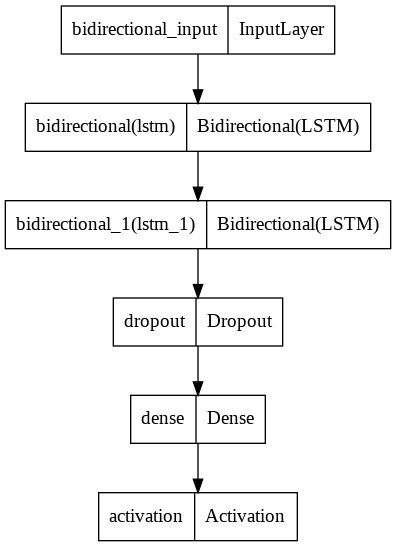

In [ ]:
# Steps Of RNN
plot_model(model, to_file='/content/drive/MyDrive/Projects/Next_Word_Prediction/plot.png', show_layer_names=True)

In [ ]:
# Compile Model

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = model.fit(X, y, validation_split=0.05, batch_size=128, epochs=10, shuffle=True).history

Epoch 1/10
1440/1440 [==============================] - 818s 564ms/step - loss: 2.5422 - accuracy: 0.2819 - val_loss: 2.4305 - val_accuracy: 0.3165
Epoch 2/10
1440/1440 [==============================] - 795s 552ms/step - loss: 2.1152 - accuracy: 0.3822 - val_loss: 2.2943 - val_accuracy: 0.3548
Epoch 3/10
1440/1440 [==============================] - 792s 550ms/step - loss: 1.9594 - accuracy: 0.4276 - val_loss: 2.1938 - val_accuracy: 0.3848
Epoch 4/10
1440/1440 [==============================] - 796s 553ms/step - loss: 1.8473 - accuracy: 0.4572 - val_loss: 2.0993 - val_accuracy: 0.4095
Epoch 5/10
1440/1440 [==============================] - 796s 553ms/step - loss: 1.7662 - accuracy: 0.4774 - val_loss: 2.0665 - val_accuracy: 0.4212
Epoch 6/10
1440/1440 [==============================] - 789s 548ms/step - loss: 1.7056 - accuracy: 0.4948 - val_loss: 2.0203 - val_accuracy: 0.4384
Epoch 7/10
1440/1440 [==============================] - 787s 546ms/step - loss: 1.6571 - accuracy: 0.5081 - val_

In [ ]:
# Save & Load model

model.save('/content/drive/MyDrive/Projects/Next_Word_Prediction/nextword1.h5')
pickle.dump(history, open("history.p", "wb"))
model = load_model('/content/drive/MyDrive/Projects/Next_Word_Prediction/nextword1.h5')
history = pickle.load(open("history.p", "rb"))

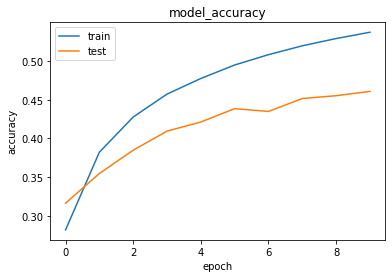

In [ ]:
# Visualisation

plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left');
plt.savefig('/content/drive/MyDrive/Projects/Next_Word_Prediction/model_accuracy.png')

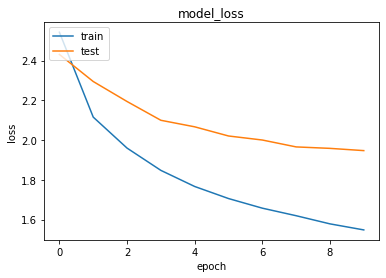

In [ ]:
# Visualisation

plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left');
plt.savefig('/content/drive/MyDrive/Projects/Next_Word_Prediction/model_loss.png')

In [ ]:
# Evaluate Model

results = model.evaluate(X, y, batch_size=128,)

1516/1516 [==============================] - 268s 176ms/step - loss: 1.4320 - accuracy: 0.5652


In [ ]:
# Prepare Test Input

def prepare_input(text):
    x = np.zeros((1, SEQUENCE_LENGTH, len(chars)))
    for t, char in enumerate(text):
        x[0, t, char_indices[char]] = 1.
        
    return x
prepare_input("This is an example of input for our LSTM".lower())

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])

In [ ]:
# Prepare Sample

def sample(preds, top_n=3):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds)
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    
    return heapq.nlargest(top_n, range(len(preds)), preds.take)

In [ ]:
# Prepare Model For Prediction

def predict_completion(text):
    original_text = text
    generated = text
    completion = ''
    while True:
        x = prepare_input(text)
        preds = model.predict(x, verbose=0)[0]
        next_index = sample(preds, top_n=1)[0]
        next_char = indices_char[next_index]
        text = text[1:] + next_char
        completion += next_char
        
        if len(original_text + completion) + 2 > len(original_text) and next_char == ' ':
            return completion

In [ ]:
# Prepare Model For Prediction

def predict_completions(text, n=3):
    x = prepare_input(text)
    preds = model.predict(x, verbose=0)[0]
    next_indices = sample(preds, n)
    return [indices_char[idx] + predict_completion(text[1:] + indices_char[idx]) for idx in next_indices]

In [ ]:
# Input

quotes = [
    "where is the class happening today at what.",
    "That which does not kill us makes us always makes us stronger.",
    "Im not upset that you lied to me, Im only mildly dissapoined and upset that from now on I cant believe you.",
    "And those who were seen dancing were thought to be insane by those who could not hear the music.",
    "It is not a good day today for me as i was attacked by some people today and i got hurt badly" ,
    "in the match that was conducted today we had sucessfuly defated our opponents"
    
]

In [ ]:
# Predict Result

for q in quotes:
    seq = q[:40].lower()
    print(seq)
    print(predict_completions(seq,10))
    print()

where is the class happening today at wh
['ich ', 'ere ', 'at ', 'ole ', 'y ', 'ut ', 'row ', 'ho ', 'shough ', 'low ']

that which does not kill us makes us alw
['ays ', 'old ', 'ing ', 'ere ', 'ust ', 'y ', 'range ', 'hated ', 'lay ', 'say ']

im not upset that you lied to me, im onl
['y ', ' the ', 'ies ', 'e ', '\nthe ', 'ow ', ', ', 'ace ', 'uce ', '. ']

and those who were seen dancing were tho
['ught ', 'se ', 'me ', 'rrough ', 'lme ', 'ne ', 'ok ', 'ther ', 'we ', ' state ']

it is not a good day today for me as i w
['as ', 'ill ', 'ould ', 'ent ', 'hole ', 'rite ', 'ull ', 'lite ', 'you ', 'winted ']

in the match that was conducted today we
[' have ', 're ', '\nshall ', 'll ', 'nt ', ', ', '. ', 'en ', 'shed ', 'ar ']

